In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import numpy as np
import torch
import torch.nn as nn
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
import math

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
random.seed(30)
print(torch.__version__)

1.0.0a0


In [4]:
def findFiles(path): 
    return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_chars
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [5]:
print('all training files=',findFiles('data/names/*.txt'))

pad_char = '#'
all_chars = string.ascii_letters + " .,;'" + pad_char
n_chars = len(all_chars)

print(unicodeToAscii('Ślusàrski'))

# Build the category_names dictionary, a list of names per language
category_names_dict = {}
all_categories = []

name_counts = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    names = readLines(filename)
    category_names_dict[category] = names
    name_counts.append(len(names))

num_samples = np.sum(name_counts)
n_categories = len(all_categories)

print('Total ',num_samples,'names across',n_categories,'categories')

all training files= ['data/names/Vietnamese.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/German.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/English.txt']
Slusarski
Total  20074 names across 18 categories


In [6]:
print('No of characters, this is the encoding dimension of each character in a name : ',n_chars)

No of characters, this is the encoding dimension of each character in a name :  58


In [7]:
print('all_categories=',all_categories,'\n')
print('category "English" has ',len(category_names_dict['English']),'names')
print(category_names_dict['English'][:5])

all_categories= ['Vietnamese', 'Czech', 'Spanish', 'Arabic', 'Irish', 'Scottish', 'Dutch', 'French', 'Italian', 'Greek', 'Korean', 'Japanese', 'Polish', 'Chinese', 'German', 'Russian', 'Portuguese', 'English'] 

category "English" has  3668 names
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


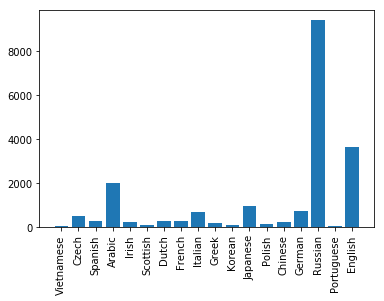

Vietnamese 73
Czech 519
Spanish 298
Arabic 2000
Irish 232
Scottish 100
Dutch 297
French 277
Italian 709
Greek 203
Korean 94
Japanese 991
Polish 139
Chinese 268
German 724
Russian 9408
Portuguese 74
English 3668


In [8]:
labels = list(category_names_dict.keys())
values = [len(names) for names in category_names_dict.values()]

plt.xticks(rotation=90)
centers = range(len(values))
plt.bar(centers, values, align='center', tick_label=labels)
plt.show()

for i,ll in enumerate(labels):
    print(ll,values[i])

[Vietnamese]
Vietnamese
True
Adding  Vietnamese 73
73
---------------
[Czech]
Czech
True
Adding  Czech 519
592
---------------
[Spanish]
Spanish
True
Adding  Spanish 298
890
---------------
[Arabic]
Arabic
True
Adding  Arabic 2000
2890
---------------
[Irish]
Irish
True
Adding  Irish 232
3122
---------------
[Scottish]
Scottish
True
Adding  Scottish 100
3222
---------------
[Dutch]
Dutch
True
Adding  Dutch 297
3519
---------------
[French]
French
True
Adding  French 277
3796
---------------
[Italian]
Italian
True
Adding  Italian 709
4505
---------------
[Greek]
Greek
True
Adding  Greek 203
4708
---------------
[Korean]
Korean
True
Adding  Korean 94
4802
---------------
[Japanese]
Japanese
True
Adding  Japanese 991
5793
---------------
[Polish]
Polish
True
Adding  Polish 139
5932
---------------
[Chinese]
Chinese
True
Adding  Chinese 268
6200
---------------
[German]
German
True
Adding  German 724
6924
---------------
[Russian]
skip
------------------
[Portuguese]
Portuguese
True
Adding

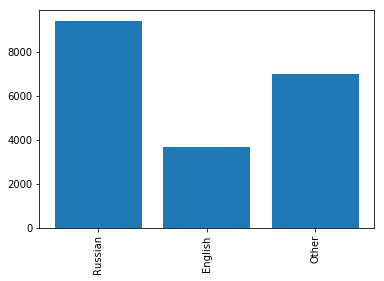

Russian 9408
English 3668
Other 6998


In [9]:
category_names_dict['Other'] = []
to_skip = ['English','Russian','Other']
for k,v in category_names_dict.items():
    print('['+k,']',sep='')
    k = k.strip()
    if k not in to_skip:
        print(k)
        print(k is not 'English' and k is not 'Russian')
        print('Adding ',k,len(v))
        category_names_dict['Other'].extend(v)
        print(len(category_names_dict['Other']))
        print('---------------')
    else:
        print('skip')
        print('------------------')
        
category_names_dict = {i:category_names_dict[i] for i in category_names_dict if i in to_skip}

labels = list(category_names_dict.keys())
values = [len(names) for names in category_names_dict.values()]

plt.xticks(rotation=90)
centers = range(len(values))
plt.bar(centers, values, align='center', tick_label=labels)
plt.show()

for i,ll in enumerate(labels):
    print(ll,values[i])
    
all_categories = list(category_names_dict.keys())
n_categories = len(all_categories)

In [10]:
print(all_categories)
print(n_categories)

['Russian', 'English', 'Other']
3


In [11]:
# Find char index from all_chars, e.g. "a" = 0
def charToIndex(char):
    return all_chars.find(char)

# Just for demonstration, turn a char into a <1 x n_chars> Tensor
def charToTensor_one_hot(char):
    tensor = torch.zeros(1, n_chars)
    tensor[0][charToIndex(char)] = 1
    return tensor

def charToTensor(char):
    tensor = torch.zeros(1,dtype=torch.long)
    tensor[0] = charToIndex(char)
    return tensor

# Turn a line into a <line_length x 1 x n_chars>,
# or an array of one-hot char vectors
def seqToTensor_one_hot(seq):
    tensor = torch.zeros(len(seq),1, n_chars)
    for idx, char in enumerate(seq):
        tensor[idx][0][charToIndex(char)] = 1
    return tensor

def seqToTensor(seq):
    tensor = torch.zeros(len(seq), dtype=torch.long)
    for idx, char in enumerate(seq):
        tensor[idx] = int(charToIndex(char))
    return tensor


print('J=',charToTensor_one_hot('J').shape)

print('Jones=',seqToTensor_one_hot('Jones').size())

print(pad_char,charToTensor_one_hot(pad_char))

J= torch.Size([1, 58])
Jones= torch.Size([5, 1, 58])
# tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1.]])


## Batch data generator, batch is the first dimension

In [12]:
def batch_data_generator(all_categories, category_names_dict, batch_size, n_chars, pad_char, shuffle):
    
    #flatten the dictionary to a list of tuples.
    dict_tuples = []
    for category,names in category_names_dict.items():
        for nm in names:
            dict_tuples.append((category,nm))
    
    num_samples = len(dict_tuples)
    num_batches = num_samples // batch_size
    
    print('batch_data_generator: num_samples =',num_samples,'num_batches = ',num_batches)
    
    epoch_num = 0
    
    while(True):
        
        if shuffle:
            random.shuffle(dict_tuples)
            random.shuffle(dict_tuples)
        indices = np.arange(num_samples)
        
        for batch_id in range(num_batches): #for each batch of names
            batch_indices = indices[batch_id * batch_size : (batch_id + 1) * batch_size]

            max_seqlen = 0 #max length of names in a batch.
            batch_names = []
            batch_labels = []
            batch_categories = []    
            name_tensors = []
            
            for b_ind in batch_indices:
                a_name = dict_tuples[b_ind][1]            #'Alex'
                category = dict_tuples[b_ind][0]          #'English'
                label = all_categories.index(category)    #17
                name_tensor = seqToTensor_one_hot(a_name)
                max_seqlen = name_tensor.shape[0] if name_tensor.shape[0] >= max_seqlen else max_seqlen
                batch_names.append(a_name)
                batch_labels.append(label)
                batch_categories.append(category)
                name_tensors.append(torch.squeeze(name_tensor))

            #for nt in name_tensors:    
            #    print('name_tensor=',nt.shape)
                
            #convert the batch list of tuples to tensors.
            #Put all the selected names into a single tensor for input to RNN
            
            pad_char_tensor = charToTensor_one_hot(pad_char) #tensor corresponding to pad_char
            
            batch_names_tensor = pad_char_tensor.repeat(batch_size, max_seqlen,1)
            
            #print('batch_names_tensor',batch_names_tensor.shape)
            
            for i,name_tensor in enumerate(name_tensors):
                num_chars = name_tensor.shape[0]
                #print(num_chars,'assigning',name_tensor.shape,'to',batch_names_tensor[i,0:num_chars,:].shape)
                batch_names_tensor[i,-num_chars:,:] = name_tensor #Left padding is done with pad_char
            
            batch_labels_tensor = torch.tensor(batch_labels,dtype=torch.long)
            
            batch_names_tensor = torch.squeeze(batch_names_tensor)
            
            yield(batch_categories, batch_names, batch_labels_tensor, batch_names_tensor,epoch_num)
            
        #done looping through all batches.
        #go to the top and permute the file indices.
        epoch_num += 1
        
        
def categoryFromOutput(an_output):
    top_n, top_i = an_output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

## Simple LSTM 
### Note how the biases and weights are initialized using xavier normal initializer, this is important for LSTM to train properly

In [13]:
class SimpleLSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim=10, printVars=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        lstm_hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size, lstm_hidden_dim, bidirectional=False, batch_first=True)
        
        self.hidden2tag = nn.Linear(hidden_dim, output_size)
        #dim=2 as we are doing softmax across the last dimension of output_size
        self.softmax = nn.Softmax(dim=2)
        
        self.hidden = None
        self.printVars = printVars #run the print statements in forward ?
        
        #initialize biases and weights
        for name, param in self.named_parameters():
            if 'bias' in name:
                nn.init.constant(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal(param)
                
                

    def init_hidden(self, batch_size):
        
        lstm_hidden_dim = self.hidden_dim
        
        #h_0 = torch.randn(1, batch_size, lstm_hidden_dim)        
        #c_0 = torch.randn(1, batch_size, lstm_hidden_dim)
        
        weight = next(self.parameters()).data
        h_0 = weight.new(1, batch_size, lstm_hidden_dim).zero_()
        c_0 = weight.new(1, batch_size, lstm_hidden_dim).zero_()
        
        return (h_0,c_0)


    def forward(self, batch_of_words):
        
        batch_size = batch_of_words.shape[0]
        
        #This is stateless LSTM, so hidden and cell states are initialized for every forward pass.
        #The hidden and cell states are not preserved across batches.
        self.hidden = self.init_hidden(batch_size)
        
        h_0 = self.hidden[0] #initial hidden state, shape (num_direction*num_layers , batch_size, hidden_dim)
        c_0 = self.hidden[1] #initial cell state, shape (num_direction*num_layers , batch_size, hidden_dim)
        
        if self.printVars:
            print('forward: h_0.shape',h_0.shape)
            print('forward: c_0.shape',c_0.shape)
            print()
        
        x = batch_of_words
        
        output, self.hidden = self.lstm(x, self.hidden)
        
        h_n = self.hidden[0] # hidden state for t = seq_len.
        c_n = self.hidden[1] # cell state for t = seq_len.
        
        if self.printVars:
            print('forward: lstm output = ',output.shape)
            print('forward: h_n = ',h_n.shape)
            print('forward: c_n = ',c_n.shape)
        
        #LSTM output : 
        output1 = self.hidden2tag(output) #make the lstm_output go through a linear layer
        
        if self.printVars:
            print('o/p of hidden2tag\n')
            print(output1.shape)
            print(output1)
        
        final_output = self.softmax(output1)
        
        if self.printVars:
            print('forward: final_output = ',final_output.shape)
            
        return final_output


### Feeding one batch of characters (a single position of a batch of names) to the RNN 

In [14]:
n_hidden = 4
batch_size = 5
shuffle = True

batch_generator = batch_data_generator(all_categories, category_names_dict, batch_size, n_chars, pad_char, shuffle)

In [15]:
print('Number of name categories, this is the no. of output categories = ',n_categories)

Number of name categories, this is the no. of output categories =  3


In [16]:
batch_categories, batch_names, batch_labels_tensor, batch_names_tensor, epoch_num = next(batch_generator)

print('Batch contents:')
for i in range(batch_size):
    print('category:',batch_categories[i],', name:',batch_names[i])
print()
    
print('Full input tensor shape = ',batch_names_tensor.shape)

print('input_tensor =',batch_names_tensor.shape)

print('batch_size=',batch_names_tensor.shape[0])
print('seq_len=',batch_names_tensor.shape[1])
print('n_chars=',n_chars)

batch_data_generator: num_samples = 20074 num_batches =  4014
Batch contents:
category: Russian , name: Beloshapka
category: Other , name: Schreck
category: English , name: May
category: Other , name: Collins
category: English , name: Bishop

Full input tensor shape =  torch.Size([5, 10, 58])
input_tensor = torch.Size([5, 10, 58])
batch_size= 5
seq_len= 10
n_chars= 58


### Just run a forward pass of the batch through LSTM to see how the output looks like. 

In [17]:
lstm_rnn = SimpleLSTM(n_chars, n_categories, hidden_dim=n_hidden,printVars = False) 
        
batch_categories, batch_names, batch_labels_tensor, batch_names_tensor, epoch_num = next(batch_generator)


print('Batch contents:')
for i in range(batch_size):
    print('category:',batch_categories[i],', name:',batch_names[i])
print()
    
print('Full input tensor shape = ',batch_names_tensor.shape)

print('input_tensor =',batch_names_tensor.shape)
emissions = lstm_rnn(batch_names_tensor)

print('Full op\n')
print(emissions)
criterion = nn.NLLLoss()
output = emissions[:,-1] #take the output from the last LSTM cell (last timestep) for predictions.

print(output.shape)
print('output=\n',output)

for op in output:
    guess, guess_i = categoryFromOutput(op)
    print(guess,guess_i)

Batch contents:
category: Russian , name: Tzarenko
category: Other , name: Thach
category: English , name: Kingdon
category: English , name: Oldfield
category: Other , name: Albuquerque

Full input tensor shape =  torch.Size([5, 11, 58])
input_tensor = torch.Size([5, 11, 58])
Full op

tensor([[[0.3482, 0.3360, 0.3158],
         [0.3548, 0.3373, 0.3079],
         [0.3577, 0.3379, 0.3043],
         [0.3362, 0.3349, 0.3289],
         [0.3269, 0.3291, 0.3440],
         [0.3336, 0.3390, 0.3274],
         [0.3416, 0.3292, 0.3292],
         [0.3293, 0.3420, 0.3287],
         [0.3221, 0.3349, 0.3430],
         [0.3257, 0.3375, 0.3369],
         [0.3241, 0.3361, 0.3398]],

        [[0.3482, 0.3360, 0.3158],
         [0.3548, 0.3373, 0.3079],
         [0.3577, 0.3379, 0.3043],
         [0.3591, 0.3383, 0.3027],
         [0.3597, 0.3384, 0.3019],
         [0.3600, 0.3385, 0.3015],
         [0.3372, 0.3353, 0.3275],
         [0.3341, 0.3381, 0.3278],
         [0.3353, 0.3431, 0.3215],
         [0.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  app.launch_new_instance()


### Define the training parameters

In [18]:
batch_size = 10
n_hidden = 128
learning_rate = 0.0001

shuffle = True #for training

#rnn = RNN(n_chars, n_hidden, n_categories)
lstm_rnn = SimpleLSTM(n_chars, n_categories, hidden_dim=n_hidden, printVars=False)

#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


#optimizer = optim.SGD(lstm_rnn.parameters(), lr=learning_rate)
optimizer = optim.Adam(lstm_rnn.parameters(), lr=learning_rate)

batch_generator = batch_data_generator(all_categories, category_names_dict, batch_size, n_chars, pad_char, shuffle)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  app.launch_new_instance()


### Define function to train : one step of training using one batch of inputs

In [19]:
def train(rnn, category_tensor, all_names_tensor,batch_size):
    
    #hidden = rnn.init_hidden(batch_size) #don't need, already called in forward of lstm.

    rnn.zero_grad()

    output = rnn(all_names_tensor)[:,-1]
    #print(category_tensor)
    loss = criterion(output, category_tensor)
    loss.backward()

    # Manual parameter updates : this also works
    # Add parameters' gradients to their values, multiplied by learning rate
    #for p in rnn.parameters():
    #    p.data.add_(p.grad.data, alpha=-learning_rate)
    
    clip = 5
    #nn.utils.clip_grad_norm_(rnn.parameters(), clip)
    optimizer.step()

    return output, loss, loss.item()/batch_size

### Training 

In [20]:
n_iters = 200000
print_every = 10000
plot_every = 5000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

curr_epoch = 0

for iter in range(1, n_iters + 1):
                                                                                
    batch_categories, batch_names, batch_labels_tensor, batch_names_tensor, epoch_num = next(batch_generator)
    output_batch, loss_tensor, loss = train(lstm_rnn, batch_labels_tensor, batch_names_tensor,batch_size)
    current_loss += loss

    # Print iter number, loss, name and guess
    if (iter % print_every == 0) or (curr_epoch!=epoch_num) :
        print('epoch=',curr_epoch)
        ii = 0
        for op in output_batch:
            guess, guess_i = categoryFromOutput(op)
            correct = '✓' if guess == batch_categories[ii] else '✗ (%s)' % batch_categories[ii]
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), 
                                                    loss, batch_names[ii], guess, correct))
            ii += 1
        print('---------------------------------------------------------------------------------')
            
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        print('current_loss=',current_loss/plot_every)
        current_loss = 0    
        
    curr_epoch = epoch_num

batch_data_generator: num_samples = 20074 num_batches =  2007
epoch= 0
2008 1% (0m 21s) 0.1042 Ibarra / Other ✓
2008 1% (0m 21s) 0.1042 Fiskin / Russian ✓
2008 1% (0m 21s) 0.1042 Parks / Other ✗ (English)
2008 1% (0m 21s) 0.1042 Almasi / Other ✓
2008 1% (0m 21s) 0.1042 Riches / Other ✗ (English)
2008 1% (0m 21s) 0.1042 Oloughlin / Russian ✗ (English)
2008 1% (0m 21s) 0.1042 Rahlin / Russian ✓
2008 1% (0m 21s) 0.1042 Vyschipan / Russian ✓
2008 1% (0m 21s) 0.1042 Cook / Other ✗ (English)
2008 1% (0m 21s) 0.1042 Murphy / Other ✓
---------------------------------------------------------------------------------
epoch= 1
4015 2% (0m 45s) 0.0795 Shahnovich / Russian ✓
4015 2% (0m 45s) 0.0795 Lohanin / Russian ✓
4015 2% (0m 45s) 0.0795 Boutros / Other ✓
4015 2% (0m 45s) 0.0795 Samuel / Other ✓
4015 2% (0m 45s) 0.0795 Losa / Other ✓
4015 2% (0m 45s) 0.0795 Clayton / Russian ✗ (English)
4015 2% (0m 45s) 0.0795 Roijakkers / Other ✓
4015 2% (0m 45s) 0.0795 Hairyuzov / Russian ✓
4015 2% (0m 45s) 0.

epoch= 13
28099 14% (4m 59s) 0.0583 Stanton / English ✓
28099 14% (4m 59s) 0.0583 Rafaj / Other ✓
28099 14% (4m 59s) 0.0583 Ilett / English ✓
28099 14% (4m 59s) 0.0583 Frary / English ✓
28099 14% (4m 59s) 0.0583 V'Yunkov / Russian ✓
28099 14% (4m 59s) 0.0583 Valk / Russian ✓
28099 14% (4m 59s) 0.0583 Doherty / English ✓
28099 14% (4m 59s) 0.0583 Baigulov / Russian ✓
28099 14% (4m 59s) 0.0583 Jmudsky / Russian ✓
28099 14% (4m 59s) 0.0583 Chukhrov / Russian ✓
---------------------------------------------------------------------------------
epoch= 14
30000 15% (5m 17s) 0.0781 Burt / Other ✗ (English)
30000 15% (5m 17s) 0.0781 Rotin / English ✗ (Russian)
30000 15% (5m 17s) 0.0781 Belokhin / Russian ✓
30000 15% (5m 17s) 0.0781 Haradurov / Russian ✓
30000 15% (5m 17s) 0.0781 Man / Other ✓
30000 15% (5m 17s) 0.0781 Jandutkin / Russian ✓
30000 15% (5m 17s) 0.0781 Tzeidler / Other ✗ (Russian)
30000 15% (5m 17s) 0.0781 V'Yunov / Russian ✓
30000 15% (5m 17s) 0.0781 Lupov / Russian ✓
30000 15% (5m

epoch= 25
52183 26% (9m 27s) 0.0656 Turusov / Russian ✓
52183 26% (9m 27s) 0.0656 Tchaly / English ✗ (Russian)
52183 26% (9m 27s) 0.0656 Perkins / English ✓
52183 26% (9m 27s) 0.0656 Mikhnov / Russian ✓
52183 26% (9m 27s) 0.0656 Paramoshin / Russian ✓
52183 26% (9m 27s) 0.0656 Waterson / English ✓
52183 26% (9m 27s) 0.0656 Dubinkin / Russian ✓
52183 26% (9m 27s) 0.0656 Gagonin / Russian ✓
52183 26% (9m 27s) 0.0656 Liu / Other ✓
52183 26% (9m 27s) 0.0656 Baumhauer / Other ✓
---------------------------------------------------------------------------------
epoch= 26
54190 27% (9m 50s) 0.0751 Eliashberg / Russian ✓
54190 27% (9m 50s) 0.0751 Pavesi / Other ✓
54190 27% (9m 50s) 0.0751 O'Sullivan / Other ✓
54190 27% (9m 50s) 0.0751 Richman / English ✗ (Russian)
54190 27% (9m 50s) 0.0751 Asghar / Other ✓
54190 27% (9m 50s) 0.0751 Awad / Other ✓
54190 27% (9m 50s) 0.0751 Haworth / English ✓
54190 27% (9m 50s) 0.0751 Vihrev / Russian ✓
54190 27% (9m 50s) 0.0751 Toichkin / Russian ✓
54190 27% (9m

epoch= 38
78274 39% (14m 36s) 0.0578 Boesch / Other ✓
78274 39% (14m 36s) 0.0578 Durasov / Russian ✓
78274 39% (14m 36s) 0.0578 Jadovsky / Russian ✓
78274 39% (14m 36s) 0.0578 Hadad / Other ✓
78274 39% (14m 36s) 0.0578 Fomintsev / Russian ✓
78274 39% (14m 36s) 0.0578 Green / English ✓
78274 39% (14m 36s) 0.0578 Evstafiev / Russian ✓
78274 39% (14m 36s) 0.0578 Diveev / Russian ✓
78274 39% (14m 36s) 0.0578 Bohler / Other ✓
78274 39% (14m 36s) 0.0578 Gil / Other ✓
---------------------------------------------------------------------------------
epoch= 39
80000 40% (14m 55s) 0.0609 Earl / English ✓
80000 40% (14m 55s) 0.0609 Noguchi / Other ✓
80000 40% (14m 55s) 0.0609 Batchaev / Russian ✓
80000 40% (14m 55s) 0.0609 Isa / Other ✓
80000 40% (14m 55s) 0.0609 Hussey / English ✓
80000 40% (14m 55s) 0.0609 Anthony / English ✓
80000 40% (14m 55s) 0.0609 Martin / Russian ✓
80000 40% (14m 55s) 0.0609 Petsyuha / Other ✗ (Russian)
80000 40% (14m 55s) 0.0609 Parratt / English ✓
80000 40% (14m 55s) 0.

epoch= 50
102358 51% (19m 18s) 0.0556 Bazzi / Other ✓
102358 51% (19m 18s) 0.0556 Atkinson / English ✓
102358 51% (19m 18s) 0.0556 Abeldyaev / Russian ✓
102358 51% (19m 18s) 0.0556 Lawton / English ✓
102358 51% (19m 18s) 0.0556 Nahas / Other ✓
102358 51% (19m 18s) 0.0556 Hadad / Other ✓
102358 51% (19m 18s) 0.0556 Mould / English ✓
102358 51% (19m 18s) 0.0556 Nosihin / Russian ✓
102358 51% (19m 18s) 0.0556 Zhirnikov / Russian ✓
102358 51% (19m 18s) 0.0556 Guzilov / Russian ✓
---------------------------------------------------------------------------------
epoch= 51
104365 52% (19m 41s) 0.0672 Nandi / Other ✗ (English)
104365 52% (19m 41s) 0.0672 Gordyushin / Russian ✓
104365 52% (19m 41s) 0.0672 Gilfillan / English ✓
104365 52% (19m 41s) 0.0672 Bakhmetoff / Russian ✓
104365 52% (19m 41s) 0.0672 Rovensky / Russian ✓
104365 52% (19m 41s) 0.0672 Yakubenko / Russian ✓
104365 52% (19m 41s) 0.0672 Kate / Other ✓
104365 52% (19m 41s) 0.0672 Steadman / English ✓
104365 52% (19m 41s) 0.0672 Kot

current_loss= 0.06690628542900076
epoch= 62
126442 63% (24m 12s) 0.0658 Jirovy / Russian ✗ (Other)
126442 63% (24m 12s) 0.0658 Swain / English ✓
126442 63% (24m 12s) 0.0658 Belousko / Russian ✓
126442 63% (24m 12s) 0.0658 Kalentiev / Russian ✓
126442 63% (24m 12s) 0.0658 Fakhoury / Other ✓
126442 63% (24m 12s) 0.0658 Asghar / Other ✓
126442 63% (24m 12s) 0.0658 Abbate / Other ✓
126442 63% (24m 12s) 0.0658 Imagawa / Other ✓
126442 63% (24m 12s) 0.0658 Dicker / English ✓
126442 63% (24m 12s) 0.0658 Bausov / Russian ✓
---------------------------------------------------------------------------------
epoch= 63
128449 64% (24m 41s) 0.0672 Gadsden / English ✓
128449 64% (24m 41s) 0.0672 Keane / Other ✗ (English)
128449 64% (24m 41s) 0.0672 Avchenko / Russian ✓
128449 64% (24m 41s) 0.0672 Geroev / Russian ✓
128449 64% (24m 41s) 0.0672 Yushin / Russian ✓
128449 64% (24m 41s) 0.0672 Galteev / Russian ✓
128449 64% (24m 41s) 0.0672 Glockner / Other ✓
128449 64% (24m 41s) 0.0672 Asghar / Other ✓
12

epoch= 74
150000 75% (29m 0s) 0.0747 Baikovski / Russian ✓
150000 75% (29m 0s) 0.0747 Philip / Russian ✗ (English)
150000 75% (29m 0s) 0.0747 Banos / Other ✓
150000 75% (29m 0s) 0.0747 Vaindrah / Russian ✓
150000 75% (29m 0s) 0.0747 Talalykin / Russian ✓
150000 75% (29m 0s) 0.0747 Papke / Russian ✗ (Other)
150000 75% (29m 0s) 0.0747 Sultana / Other ✓
150000 75% (29m 0s) 0.0747 Nagatsuka / Other ✓
150000 75% (29m 0s) 0.0747 Wrenn / English ✓
150000 75% (29m 0s) 0.0747 D'amore / Other ✓
---------------------------------------------------------------------------------
current_loss= 0.06587289711475365
epoch= 74
150526 75% (29m 6s) 0.0651 Kerby / English ✓
150526 75% (29m 6s) 0.0651 Tuma / Other ✓
150526 75% (29m 6s) 0.0651 Jukhno / Russian ✓
150526 75% (29m 6s) 0.0651 Djemilev / Russian ✓
150526 75% (29m 6s) 0.0651 Lowbridge / English ✓
150526 75% (29m 6s) 0.0651 Said / Other ✓
150526 75% (29m 6s) 0.0651 Rokhlin / Russian ✓
150526 75% (29m 6s) 0.0651 Chepelkin / Russian ✓
150526 75% (29m 

epoch= 85
172603 86% (33m 5s) 0.0643 Grametsky / Russian ✓
172603 86% (33m 5s) 0.0643 Oneill / English ✓
172603 86% (33m 5s) 0.0643 Homer / Other ✗ (English)
172603 86% (33m 5s) 0.0643 D arcy / English ✓
172603 86% (33m 5s) 0.0643 Takasu / Other ✓
172603 86% (33m 5s) 0.0643 Esenin / Russian ✓
172603 86% (33m 5s) 0.0643 Botros / Other ✓
172603 86% (33m 5s) 0.0643 Portnenko / Russian ✓
172603 86% (33m 5s) 0.0643 Yakhlakov / Russian ✓
172603 86% (33m 5s) 0.0643 Renskov / Russian ✓
---------------------------------------------------------------------------------
epoch= 86
174610 87% (33m 30s) 0.0590 Jeltoukhov / Russian ✓
174610 87% (33m 30s) 0.0590 Qureshi / Other ✓
174610 87% (33m 30s) 0.0590 Antoun / Other ✓
174610 87% (33m 30s) 0.0590 Jankilevsky / Russian ✓
174610 87% (33m 30s) 0.0590 Heinrichs / Other ✓
174610 87% (33m 30s) 0.0590 Dzhisev / Russian ✓
174610 87% (33m 30s) 0.0590 Knuckles / English ✓
174610 87% (33m 30s) 0.0590 Tselikov / Russian ✓
174610 87% (33m 30s) 0.0590 Tihankin 

epoch= 97
196687 98% (37m 13s) 0.0658 Valentine / English ✓
196687 98% (37m 13s) 0.0658 Matzotsky / Russian ✓
196687 98% (37m 13s) 0.0658 Davenport / English ✓
196687 98% (37m 13s) 0.0658 Zhigalev / Russian ✓
196687 98% (37m 13s) 0.0658 Rory / English ✗ (Other)
196687 98% (37m 13s) 0.0658 Handal / Other ✓
196687 98% (37m 13s) 0.0658 Sommer / Other ✓
196687 98% (37m 13s) 0.0658 Roffey / English ✓
196687 98% (37m 13s) 0.0658 Goulding / English ✓
196687 98% (37m 13s) 0.0658 Giersig / Other ✓
---------------------------------------------------------------------------------
epoch= 98
198694 99% (37m 35s) 0.0757 Khouri / Other ✓
198694 99% (37m 35s) 0.0757 Avetyan / Russian ✓
198694 99% (37m 35s) 0.0757 Minobe / English ✗ (Other)
198694 99% (37m 35s) 0.0757 Norman / English ✓
198694 99% (37m 35s) 0.0757 Kranz / Other ✓
198694 99% (37m 35s) 0.0757 Mangnall / English ✓
198694 99% (37m 35s) 0.0757 Berg / Other ✓
198694 99% (37m 35s) 0.0757 Alber / English ✓
198694 99% (37m 35s) 0.0757 Riseborou

### Plot the average loss for epochs

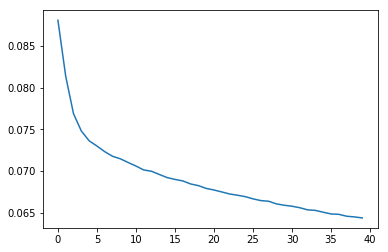

In [21]:
plt.figure()
plt.plot(all_losses)
plt.show()

## Run multiple batches of predictions to see get a sense of training accuracy. 

In [32]:
acc = 0
tot = 0
for p_iter in range(10):
    batch_categories, batch_names, batch_labels_tensor, batch_names_tensor, epoch_num = next(batch_generator)
    output_batch = lstm_rnn(batch_names_tensor)[:,-1]

    ii = 0
    for op in output_batch:
        guess, guess_i = categoryFromOutput(op)
        if guess == batch_categories[ii] :
            correct = '✓'
            acc += 1
        else:
            '✗ (%s)' % batch_categories[ii]
        print(batch_names[ii], guess, correct)
        ii += 1
        tot += 1

print('\nAcc = %f'%(acc/tot))

Winward English ✓
V'Yunkov Russian ✓
Boutros Other ✓
Hedley English ✓
Forth English ✓
Boulos Other ✓
Anorin Russian ✓
Tomeev Russian ✓
Docker English ✓
Awdoshin Russian ✓
Simmon Other ✓
Balandin Russian ✓
Jemlikhanov Russian ✓
Musakov Russian ✓
Truhin Russian ✓
Avinovitski Russian ✓
Murtazin Russian ✓
Toma Other ✓
Berezyuk Russian ✓
Babiy Russian ✓
Shakhnarovich Russian ✓
Dorrington English ✓
Fin Russian ✓
Pochkailo Other ✓
Zhalkovsky Russian ✓
Yakimchuk Russian ✓
Abrosimoff Russian ✓
Odea Other ✓
Qureshi Other ✓
Judakhin Russian ✓
Chursalov Russian ✓
Pavot English ✓
Grygarova Other ✓
Saliba Other ✓
Dobbins English ✓
Shiotani Other ✓
Abulgatin Russian ✓
Seif Other ✓
Daher Other ✓
Kachanovsky Russian ✓
Flanders English ✓
Coghlan Other ✓
Kassab Other ✓
Bazhenin Russian ✓
Sarkis Other ✓
Dubrovo Russian ✓
Ramos Other ✓
Furniss English ✓
Kalb Other ✓
Muraoka Other ✓
Cline English ✓
Gorchilin Russian ✓
Schuster Other ✓
Koo Other ✓
Hankoev Russian ✓
Jakubov Russian ✓
Lovell English ✓
Filippov